<br>

## Εισαγωγή

**[Project Description]**

Μια εργασία ανάλυσης συναισθημάτων σχετικά με τα προβλήματα κάθε μεγάλης αεροπορικής εταιρείας των ΗΠΑ. Τα δεδομένα του Twitter πάρθηκαν από τον Φεβρουάριο του 2015 και ζητήθηκε από τους annotators να ταξινομήσουν πρώτα θετικά, αρνητικά και ουδέτερα tweets, ακολουθούμενα από την κατηγοριοποίηση των αρνητικών λόγων (όπως "καθυστέρηση πτήσης" ή "αγενής εξυπηρέτηση").

Για παράδειγμα, περιέχει εάν το συναίσθημα των tweets σε αυτό το σύνολο ήταν θετικό, ουδέτερο ή αρνητικό για έξι αεροπορικές εταιρείες των ΗΠΑ:

Οι πληροφορίες των main attributes για αυτό το έργο είναι οι εξής:

* **`alirline_sentiment`** : Ταξινόμηση συναισθημάτων. (positivie, neutral, and negative)
* **`negativereason`** : Ο λόγος για την αρνητική γνώμη
* **`airline`** : Όνομα των 6 Αεροπορικών εταιρειών ('Delta', 'United', 'Southwest', 'US Airways', 'Virgin America', 'American')
* **`text`** : Η γνώμη του πελάτη

<br>

In [7]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import seaborn as sns

import sqlite3

import pickle, joblib

<br>

## Φόρτωση δεδομένων

In [8]:
connection = sqlite3.connect(r"C:\Users\video\DatabaseName.db")
query = "SELECT * FROM sqlite_master"
db = pd.read_sql_query(sql = query, con = connection)
db

,type,name,tbl_name,rootpage,sql
0,table,Tweets,Tweets,2,"CREATE TABLE ""Tweets""(\n""tweet_id"" TEXT, ""airl..."


In [9]:
query = "SELECT airline, text, negativereason, airline_sentiment AS sentiment FROM 'Tweets'"

df = pd.read_sql_query(sql = query, con = connection)

display(df.shape, df.head(), df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   airline         14640 non-null  object
 1   text            14640 non-null  object
 2   negativereason  14640 non-null  object
 3   sentiment       14640 non-null  object
dtypes: object(4)
memory usage: 457.6+ KB


(14640, 4)

,airline,text,negativereason,sentiment
0,Virgin America,@VirginAmerica What @dhepburn said.,,neutral
1,Virgin America,@VirginAmerica plus you've added commercials t...,,positive
2,Virgin America,@VirginAmerica I didn't today... Must mean I n...,,neutral
3,Virgin America,@VirginAmerica it's really aggressive to blast...,Bad Flight,negative
4,Virgin America,@VirginAmerica and it's a really big bad thing...,Can't Tell,negative


None

<br> 

* **`airline`** : Δεν περιέχει null δεδομένα. Θα προσθέσω αυτό το χαρακτηριστικό στα stopwords.
* **`name`** : Θα προσθέσω αυτό το χαρακτηριστικό στα stopwords.
* **`text`** : Δεν περιέχει null δεδομένα. Κάθε κείμενο ξεκινά με @ λόγω του  twitter. Επιπλέον, μπορούμε να δούμε emoji στο κείμενο.
* **`negativereason`** : Άδειο αν το `sentiment` δεν είναι 'αρνητικό'.
* **`alirline_sentiment`** : Δεν περιέχει null δεδομένα.

<br>

## Στατιστικά

### Συνολικός αριθμός ανά αεροπορική εταιρεία

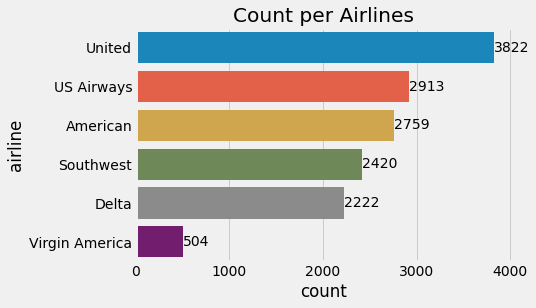

In [10]:
ax = sns.countplot(data = df, y = 'airline',
                   order = df.airline.value_counts().index)
ax.bar_label(ax.containers[0])
ax.set_title('Count per Airlines',)
                                    
plt.show()

<br>

### Αναλογία Συναισθημάτων

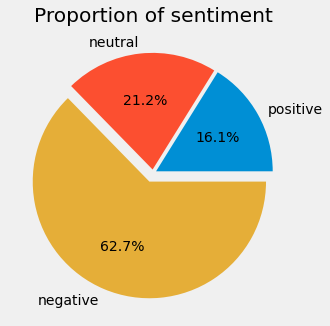

In [11]:
x = df.sentiment.value_counts().sort_values()

plt.figure(figsize=(5, 5))
ax = plt.pie(x = x, labels=x.index, autopct = '%1.1f%%', explode = [0.03, 0.03, 0.08])
plt.title('Proportion of sentiment')

plt.show()

In [12]:
a = df.groupby(['airline', 'sentiment'])['sentiment'].count().unstack()
# a['total'] =  [a.values[x].sum() for x in range(0,6)]
a

sentiment,negative,neutral,positive
airline,,,
American,1960,463,336
Delta,955,723,544
Southwest,1186,664,570
US Airways,2263,381,269
United,2633,697,492
Virgin America,181,171,152


In [13]:
# b = sorted(list(dict(df.airline.value_counts()).items()), key = lambda x : x[0])
# print(b)

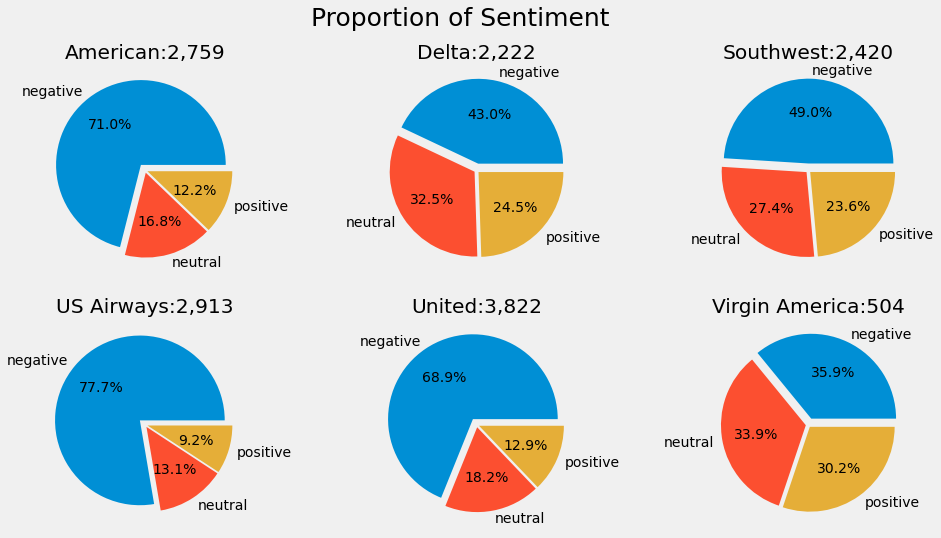

In [14]:
fig, axes = plt.subplots(2, 3, figsize = (15, 8))
axes = axes.flatten()
for i, ax in zip(range(0, 6), axes):
    temp = a.iloc[i]    
    ax.pie(x = temp, labels = temp.index, autopct = '%1.1f%%', explode = [0.08, 0.03, 0.03])
    ax.set_title(f"{a.index[i]}:{format(a.values[i].sum(),',')}")

plt.suptitle("Proportion of Sentiment", fontsize = 25)    
plt.show()

<br>

Νομίζω ότι είναι ενδιαφέρον να συγκρίνουμε τα δεδομένα του twitter με άλλα πραγματικά δεδομένα για να ελέγξουμε τη συνοχή του συναισθήματος του πελάτη σε κάθε αεροπορική εταιρεία.

<br>

**[The overall performances of the largest U.S. airlines on the Middle Seat scorecard, from 2015 to 2017]**

<img src='https://si.wsj.net/public/resources/images/BN-WX851_backgr_4U_20180110102611.jpg'>


source: https://www.wsj.com/articles/the-best-and-worst-airlines-of-2017-1515594783

<br>

* **`American`**, **`US Airways`**: Οι αμερικανικές αεροπορικές εταιρείες συγχώνευσαν την US Airways το 2015. Συμπτωματικά ή όχι, το συναίσθημα για αυτές τις δύο αεροπορικές εταιρείες είναι γενικά αρνητικό. Επιπλέον, οι παραπάνω συνολικές επιδόσεις από το 2015 έως το 2017 εξηγούν ότι είναι κάπως λογικό να νιώθει κάποιος αρνητικά μαζί τους.

* **`United`**: 68.9% ένιωθαν αρνητικά για αυτή.

* **`Delta`**, **`Southwest`**: Καλύτερα από την `American` και την `US Airways`, καθώς το ποσοστό του αρνητικού συναισθήματος είναι μικρότερο από 50%.

* **`Virgin America`**: Η αναλογία των συναισθημάτων είναι πολύ καλά ισορροπημένη, αλλά ο αριθμός δεν είναι τόσο μεγάλος όσο των άλλων. Συγχωνεύτηκε με την Αλάσκα το 2017.

<br>

### Λόγος για αρνητικό συναίσθημα

In [15]:
print(df.negativereason.unique())

['' 'Bad Flight' "Can't Tell" 'Late Flight' 'Customer Service Issue'
 'Flight Booking Problems' 'Lost Luggage' 'Flight Attendant Complaints'
 'Cancelled Flight' 'Damaged Luggage' 'longlines']


In [16]:
print(df[df.negativereason == '']['sentiment'].unique())
print(df[df.negativereason != '']['sentiment'].unique())

['neutral' 'positive']
['negative']


Το negativereason υπάρχει μόνο στα tweets με αρνητικά συναισθήματα.
<br>

In [17]:
df_neg = df[df.sentiment == 'negative']
display(df_neg.shape, df_neg.head())

(9178, 4)

,airline,text,negativereason,sentiment
3,Virgin America,@VirginAmerica it's really aggressive to blast...,Bad Flight,negative
4,Virgin America,@VirginAmerica and it's a really big bad thing...,Can't Tell,negative
5,Virgin America,@VirginAmerica seriously would pay $30 a fligh...,Can't Tell,negative
15,Virgin America,@VirginAmerica SFO-PDX schedule is still MIA.,Late Flight,negative
17,Virgin America,@VirginAmerica I flew from NYC to SFO last we...,Bad Flight,negative


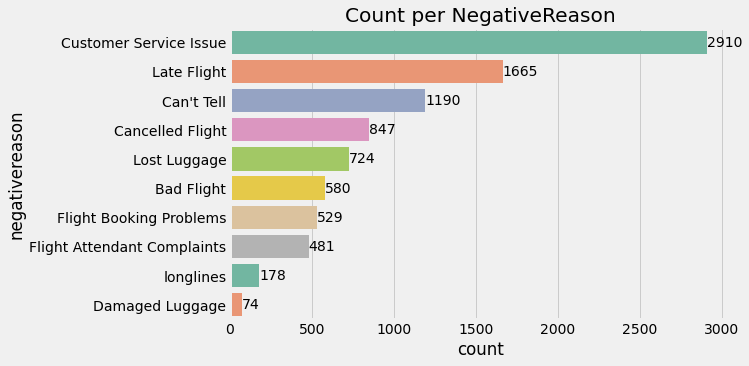

In [18]:
plt.figure(figsize=(8,5))
ax = sns.countplot(data = df_neg, y = 'negativereason',
                   palette='Set2',
                   order = df_neg.negativereason.value_counts().index)

ax.bar_label(ax.containers[0])
ax.set_title('Count per NegativeReason')

plt.show()

<br>
Το θέμα της εξυπηρέτησης πελατών, στο σύνολό του, είναι ο κύριος λόγος για το αρνητικό κλίμα προς τις αεροπορικές εταιρείες.

Ακολουθεί λεπτομερής ταξινομηση με βάση το όνομα των αεροπορικών εταιρειών.
<br>

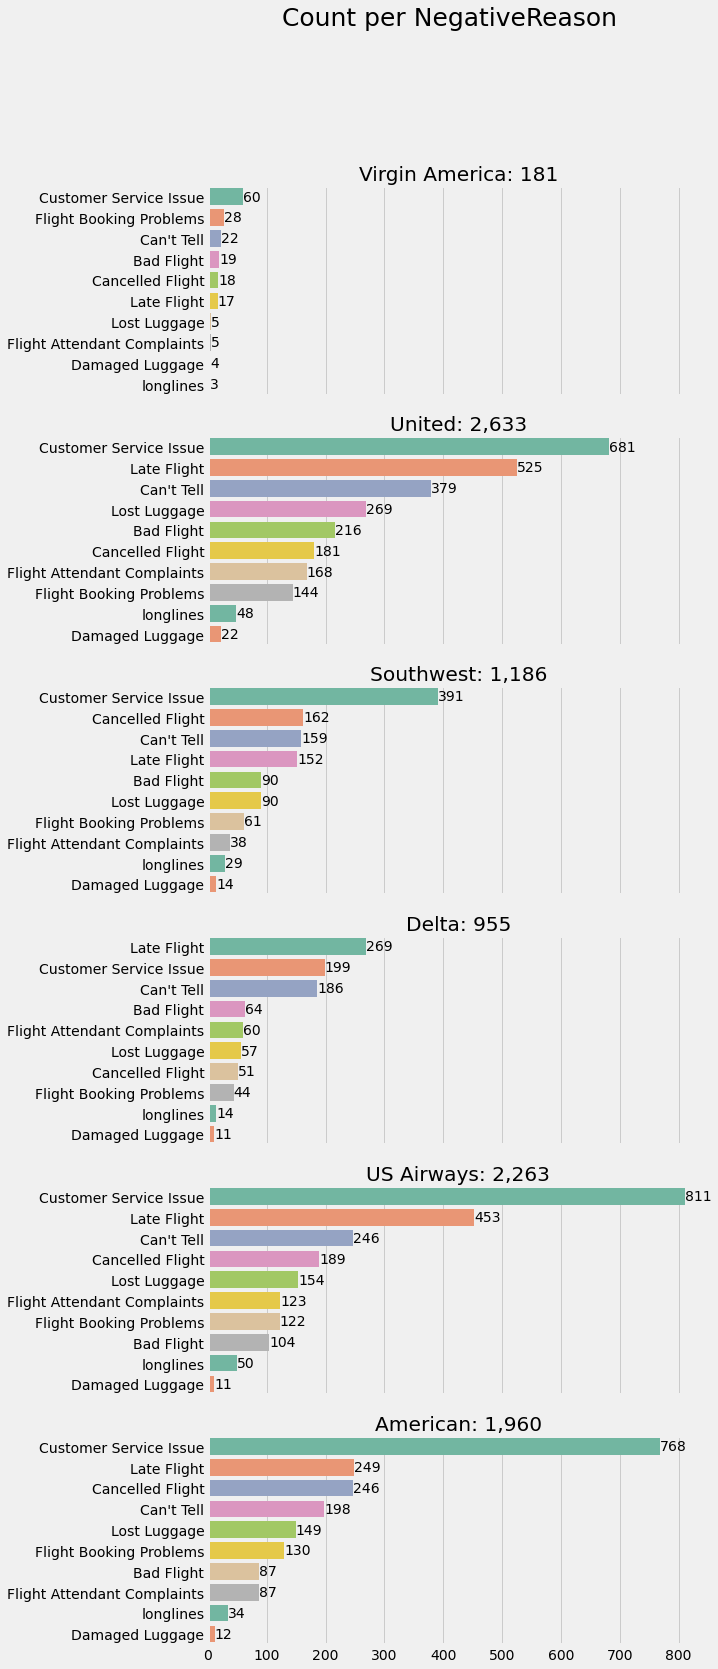

In [19]:
fig, axes = plt.subplots(6, 1, figsize=(8, 25), sharex=True)
axes = axes.flatten()
names = df_neg['airline'].unique()

for name, n in zip(names, axes):
    ax = sns.countplot(data = df_neg[df_neg.airline==name], y = 'negativereason',
                       palette='Set2',
                       order = df_neg[df_neg.airline==name].negativereason.value_counts().index, ax = n)
    ax.bar_label(ax.containers[0])
    ax.set_title(f"{name}: {format(len(df_neg[df_neg.airline==name]),',')}")
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.suptitle("Count per NegativeReason", fontsize = 25)
plt.show()

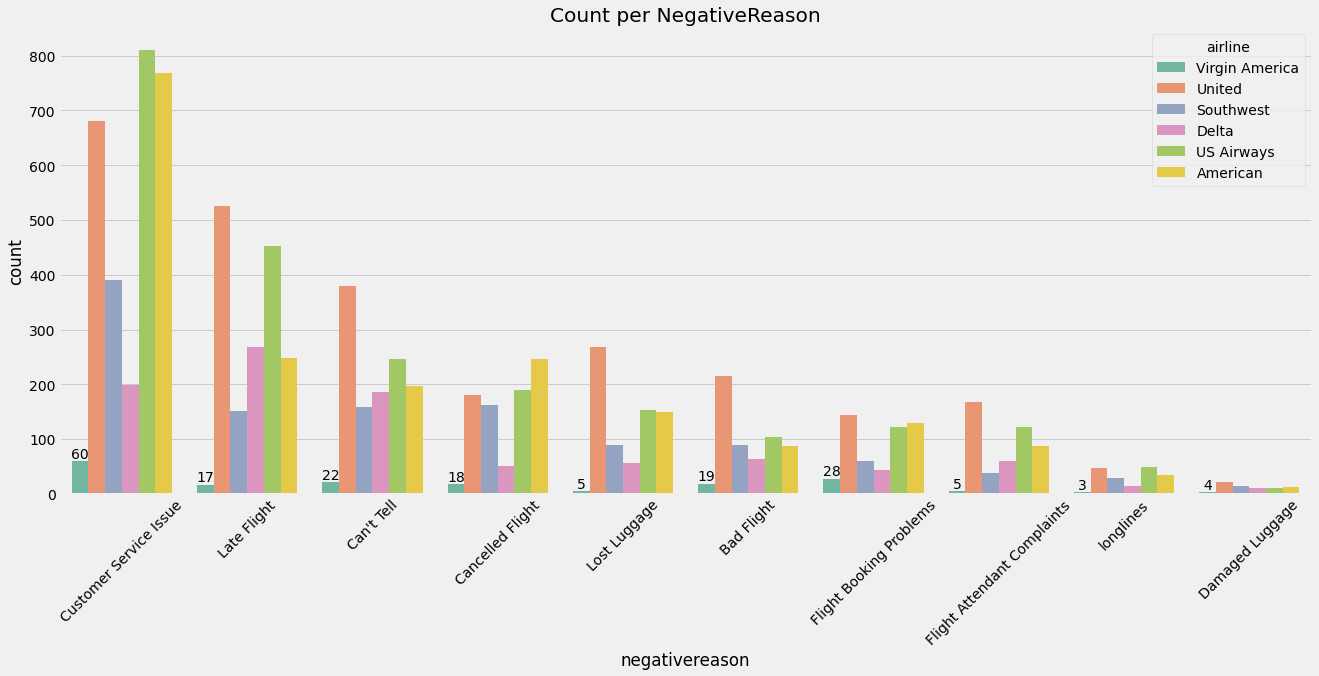

In [20]:
plt.figure(figsize=(20,8))
ax = sns.countplot(data = df_neg, x = 'negativereason',
                   palette='Set2',
                   order = df_neg.negativereason.value_counts().index, hue = 'airline')

ax.bar_label(ax.containers[0])
ax.set_title('Count per NegativeReason')
plt.xticks(rotation=45)
plt.show()

In [21]:
names = df.airline.unique()
for name in names:
    print(f"{name} : Out of total {format(len(df[df.airline == name]),',')}customers, {(len(df_neg[df_neg.airline == name]) / len(df[df.airline == name]))*100:.1f}% feel negative.\n")

Virgin America : Out of total 504customers, 35.9% feel negative.

United : Out of total 3,822customers, 68.9% feel negative.

Southwest : Out of total 2,420customers, 49.0% feel negative.

Delta : Out of total 2,222customers, 43.0% feel negative.

US Airways : Out of total 2,913customers, 77.7% feel negative.

American : Out of total 2,759customers, 71.0% feel negative.



<br>

* **`American`, `US Airways`, `Southwest`**: Τα παράπονα σχετικά με το ζήτημα της εξυπηρέτησης πελατών είναι σχετικά υψηλά.

* **`United`** : Το πρόβλημα εξυπηρέτησης πελατών είναι το μεγαλύτερο, αλλά οι πελάτες αυτής της αεροπορικής εταιρείας αντιμετώπισαν καθυστερημένες πτήσεις πιο συχνά από άλλους. Το ζήτημα των χαμένων αποσκευών συνέβη σχετικά υψηλό.

* **`Delta`**: Η εξυπηρέτηση πελατών δεν φαίνεται κακή, αλλά οι περισσότεροι πελάτες βίωσαν καθυστερημένη πτήση.

* **`Virgin America`**: Κυρίως για την εξυπηρέτηση πελατών ακολουθούμενη από πρόβλημα κράτησης πτήσεων.

<br>

## Προεπεξεργασία κειμένου

* Το κείμενο του tweet αποτελείται από 103 μήκος κατά μέσο όρο.
* Το ελάχιστο μήκος είναι 12 και το μέγιστο ένα είναι 186.

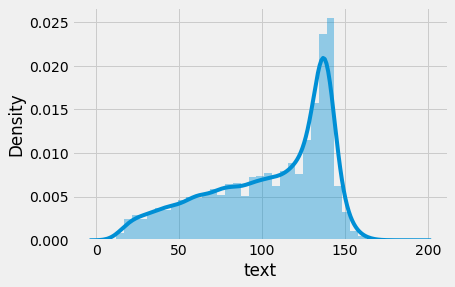

In [22]:
sns.distplot(df.text.str.len())

plt.show()

In [23]:
df.text.str.len().describe()

count    14640.000000
mean       103.822063
std         36.277339
min         12.000000
25%         77.000000
50%        114.000000
75%        136.000000
max        186.000000
Name: text, dtype: float64

### Διαδικασία
* Regular expression
* Tokenization
* Checking Stopwords

In [24]:
# We will go over the sampled text as below.
# Every tweets share the common rule starting with @ + airlines' name.
# We can also see there are http formats, emojis, and hashtag

print(df.text[0].split(),'\n')
print(df.text[1].split(),'\n')
print(df.text[100].split(),'\n')
print(df.text[1000].split(),'\n')
print(df.text[10000].split())

['@VirginAmerica', 'What', '@dhepburn', 'said.'] 

['@VirginAmerica', 'plus', "you've", 'added', 'commercials', 'to', 'the', 'experience...', 'tacky.'] 

['@VirginAmerica', 'trying', 'to', 'add', 'my', 'boy', 'Prince', 'to', 'my', 'ressie.', 'SF', 'this', 'Thursday', '@VirginAmerica', 'from', 'LAX', 'http://t.co/GsB2J3c4gM'] 

['@united', 'how', 'can', 'you', 'not', 'put', 'my', 'bag', 'on', 'plane', 'to', 'Seattle.', 'Flight', '1212.', 'Waiting', 'in', 'line', 'to', 'talk', 'to', 'someone', 'about', 'my', 'bag.', 'Status', 'should', 'matter.'] 

['@USAirways', 'waiting', 'all', 'day', 'at', 'ATL', 'since', 'flight', 'this', 'am', 'Cancelled', 'Flightled.', '1', 'standby', 'told', 'no', 'seats', 'and', 'group', 'of', '15', 'shows', 'up', 'Late', 'Flight', 'and', 'gets', 'on', 'to', 'PHL']


In [25]:
# !pip install nltk

In [26]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
nltk.download('punkt')

def clean_text(d):
    pattern = r'[^a-zA-Z\s]'
    text = re.sub(pattern, '', d)
    return text

names = ['delta', 'deltaair', 'united', 'unitedair', 'southwest', 'southwestair', 'usairways',
         'virginamerica', 'american', 'americanair', 'jetblue', 'jetblues', 'usairway',
         'flight', 'airline', 'airlines']

# I thought the words related the name of airlines are not relevant to the sentiment analysis
# Therefore I decided to append the above names into the list of stop words.
def clean_stopword(d):
    stop_words = stopwords.words('english')
    for name in names:
        stop_words.append(name)
    return " ".join([w.lower() for w in d.split() if w.lower() not in stop_words and len(w) > 1])

def tokenize(d):
    return word_tokenize(d)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\video\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\video\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [27]:
df['final_text']= df.text.apply(clean_text).apply(clean_stopword).apply(tokenize)
df.final_text.head()

0                                     [dhepburn, said]
1    [plus, youve, added, commercials, experience, ...
2    [didnt, today, must, mean, need, take, another...
3    [really, aggressive, blast, obnoxious, enterta...
4                            [really, big, bad, thing]
Name: final_text, dtype: object

In [28]:
print(" ".join(df.final_text[0]),'\n')
print(" ".join(df.final_text[1]),'\n')
print(" ".join(df.final_text[100]),'\n')
print(" ".join(df.final_text[1000]),'\n')
print(" ".join(df.final_text[10000]))

dhepburn said 

plus youve added commercials experience tacky 

trying add boy prince ressie sf thursday lax httptcogsbjcgm 

put bag plane seattle waiting line talk someone bag status matter 

waiting day atl since cancelled flightled standby told seats group shows late gets phl


<br>

## Ανάλυση Κειμένου

### Προσέγγιση με βάση Lexicon

Η προσέγγιση που βασίζεται στο λεξικό περιλαμβάνει τον υπολογισμό του προσανατολισμού για ένα έγγραφο από τον σημασιολογικό προσανατολισμό λέξεων ή φράσεων στο έγγραφο. Χρησιμοποιεί λεξικά λέξεων που σχολιάζονται με τον σημασιολογικό προσανατολισμό (semantic orientation) ή την πολικότητα (polarity) της λέξης.

Εδώ θα προσπαθήσουμε απλώς να επαληθεύσουμε ότι το λεξικό λειτουργεί καλά για να ταξινομήσουμε το συναίσθημα που έχει ήδη κατανεμηθεί από τους πραγματικούς πελάτες.

#### Vader

Το Vader είναι ένα λεξικό που δημιουργήθηκε για την ανάλυση συναισθημάτων από δεδομένα κειμένου στα μέσα κοινωνικής δικτύωσης.

Επιστρέφει τη σύνθετη βαθμολογία πολικότητας μιας πρότασης αφού υπολογίσει την αρνητική, την ουδέτερη και τη θετική βαθμολογία κάθε λέξης σε μια πρόταση.

Μπορούμε να χρησιμοποιήσουμε το Vader από το inner module στο nltk καθώς και από το Python API [vaderSentiment](https://pypi.org/project/vaderSentiment/).

Το VADER έχει πολλά πλεονεκτήματα σε σχέση με τις παραδοσιακές μεθόδους ανάλυσης συναισθήματος: [source](https://ichi.pro/ko/python-eseo-vaderleul-sayonghayeo-gamjeong-bunseog-dansunhwa-sosyeol-midieo-tegseuteu-274770204542255)

* **Λειτουργεί πολύ καλά με κείμενο τύπου social media**, αλλά γενικεύεται εύκολα σε πολλούς τομείς.
* Δεν απαιτεί δεδομένα εκπαίδευσης, αλλά αποτελείται από ένα γενικευμένο, βασισμένο στην ισορροπία, επιμελημένο "gold standard psychological vocabulary".
* Είναι αρκετά γρήγορο για χρήση στο διαδίκτυο με live streaming,
* Η αντιστάθμιση ταχύτητας-απόδοσης δεν είναι σοβαρή.



In [29]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
vader = SentimentIntensityAnalyzer()
vader.polarity_scores(" ".join(df.final_text[0]))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\video\AppData\Roaming\nltk_data...


{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

In [30]:
texts = [" ".join(df.final_text[i]) for i in range(len(df))]

print(df.text[0])
print(texts[0])
print(vader.polarity_scores(texts[0]), f'--> Actual Classification: {df.sentiment[0]}', '\n')

print(df.text[1])
print(texts[1])
print(vader.polarity_scores(texts[1]), f'--> Actual Classification: {df.sentiment[1]}', '\n')

print(df.text[10])
print(texts[10])
print(vader.polarity_scores(texts[10]), f'--> Actual Classification: {df.sentiment[10]}', '\n')

print(df.text[100])
print(texts[100])
print(vader.polarity_scores(texts[100]), f'--> Actual Classification: {df.sentiment[100]}', '\n')

print(df.text[1000])
print(texts[1000])
print(vader.polarity_scores(texts[1000]), f'--> Actual Classification: {df.sentiment[1000]}', '\n')

print(df.text[10000])
print(texts[10000])
print(vader.polarity_scores(texts[10000]), f'--> Actual Classification: {df.sentiment[10000]}')

@VirginAmerica What @dhepburn said.
dhepburn said
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0} --> Actual Classification: neutral 

@VirginAmerica plus you've added commercials to the experience... tacky.
plus youve added commercials experience tacky
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0} --> Actual Classification: positive 

@VirginAmerica did you know that suicide is the second leading cause of death among teens 10-24
know suicide second leading cause death among teens
{'neg': 0.583, 'neu': 0.417, 'pos': 0.0, 'compound': -0.8555} --> Actual Classification: neutral 

@VirginAmerica trying to add my boy Prince to my ressie. SF this Thursday @VirginAmerica from LAX http://t.co/GsB2J3c4gM
trying add boy prince ressie sf thursday lax httptcogsbjcgm
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0} --> Actual Classification: neutral 

@united how can you not put my bag on plane to Seattle. Flight 1212. Waiting  in line to talk to someone about my bag. Status sho

<br>

Αντιλαμβανόμαστε ότι ορισμένες σαφείς προτάσεις θα μπορούσαν να ταξινομηθούν ως σχεδόν ίδιες με την πραγματική ταξινόμηση.

Αλλά οι πολύ διφορούμενες (ή σαρκαστικές) προτάσεις όπως:
* Wanted to get my bag benefit, but instead get $25 pricing on all three tickets. When adding a card, MP Visa is only option. @united
* @SouthwestAir I'm an A-list Preferred customer and very loyal SWA. However, your inflight wifi is no better today than it was 4 years ago.

Μερικές φορές ο Vader δεν λειτούργησε καλά για να ταξινομήσει το πραγματικό συναίσθημα και αυτό δείχνει τον περιορισμό του τρέχοντος NLP και τον τρόπο που πρέπει να ακολουθήσουμε ταυτόχρονα.


<br>

<br>

### WordCloud : Ανάλυση λέξεων-κλειδιών

Το WordCloud είναι ένας από τους ευκολότερους τρόπους για να δείξουμε ποια λέξη εμφανίζεται κυρίως (συχνά) στο σύνολο των προτάσεων.

Αλλά μπορεί να είναι μόνο ένα από τα κομμάτια οπτικοποίησης εάν δεν υπάρχει κατάλληλη προεπεξεργασία κειμένου πριν το σχεδιάσουμε.

In [31]:
# preprocessing before drawing wordcloud separating the sentiment.

positive = df[df.sentiment == 'positive'].text.apply(clean_text).apply(clean_stopword).apply(tokenize)
positive = [" ".join(positive.values[i]) for i in range(len(positive))]
positive = [" ".join(positive)][0]

negative = df[df.sentiment == 'negative'].text.apply(clean_text).apply(clean_stopword).apply(tokenize)
negative = [" ".join(negative.values[i]) for i in range(len(negative))]
negative = [" ".join(negative)][0]

neutral = df[df.sentiment == 'neutral'].text.apply(clean_text).apply(clean_stopword).apply(tokenize)
neutral = [" ".join(neutral.values[i]) for i in range(len(neutral))]
neutral = [" ".join(neutral)][0]

print(len(positive), len(negative), len(neutral))

115931 591416 151075


In [34]:
from wordcloud import WordCloud

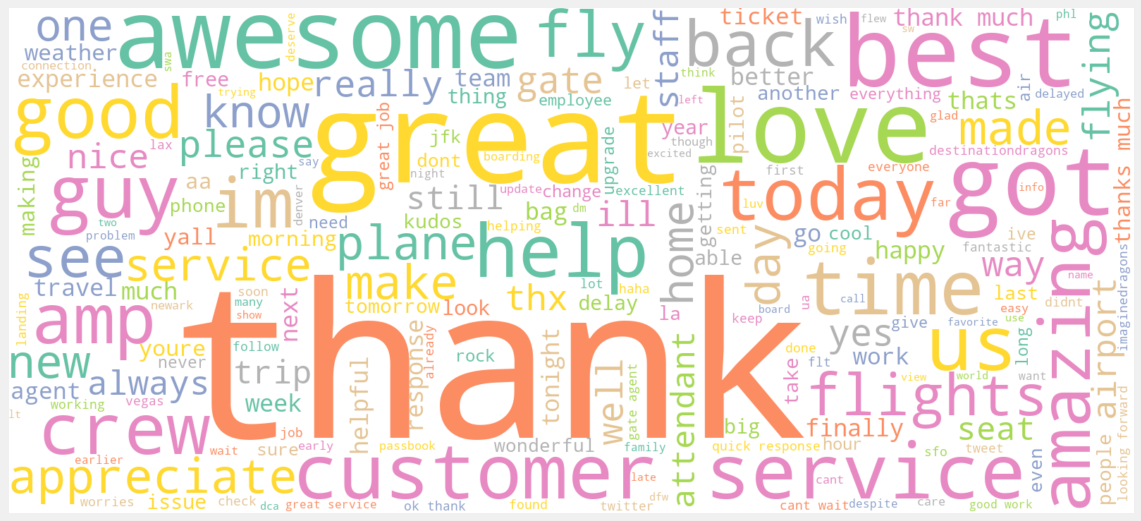

In [35]:
plt.figure(figsize=(18,15))
wc_positive = WordCloud(min_font_size=3,max_words=200,width=1600,height=720,
                       colormap = 'Set2', background_color='white').generate(positive)

plt.imshow(wc_positive,interpolation='bilinear')
plt.xticks([])
plt.yticks([])
plt.grid(False)

<br>
Μπορούμε να δούμε πολλές θετικές λέξεις όπως «ευχαριστώ», «υπέροχο», «αγάπη» κ.λπ.
<br>

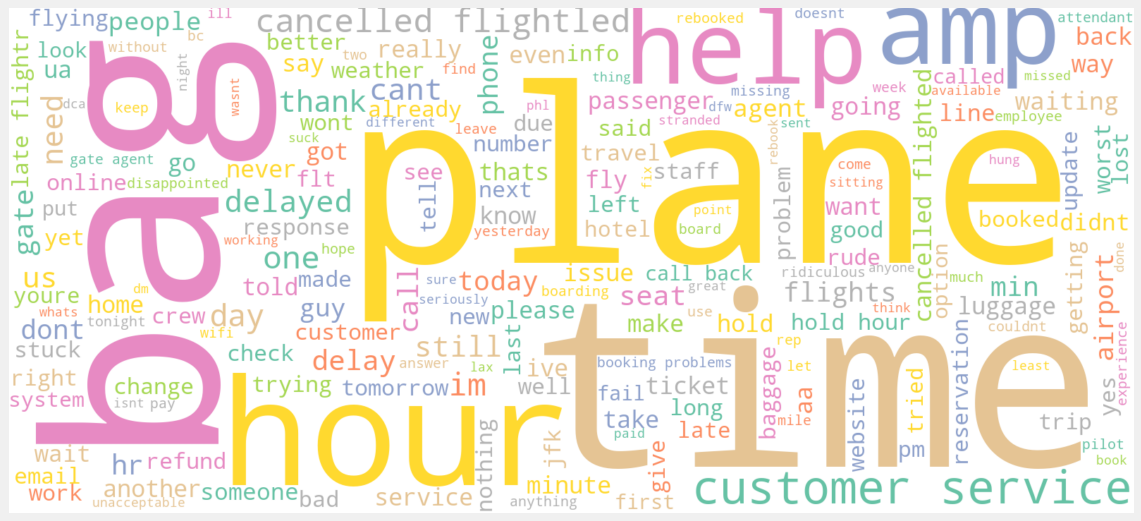

In [36]:
plt.figure(figsize=(18,15))
wc_negative = WordCloud(min_font_size=3,max_words=200,width=1600,height=720,
                       colormap = 'Set2', background_color='white').generate(negative)

plt.imshow(wc_negative,interpolation='bilinear')
plt.xticks([])
plt.yticks([])
plt.grid(False)

<br>

Οι κύριες λέξεις που μπορούμε να δούμε στο WC του αρνητικού συναισθήματος είναι «αεροπλάνο», «τσάντα», «ώρα», «πελάτης», «υπηρεσία» κ.λπ.

<br>

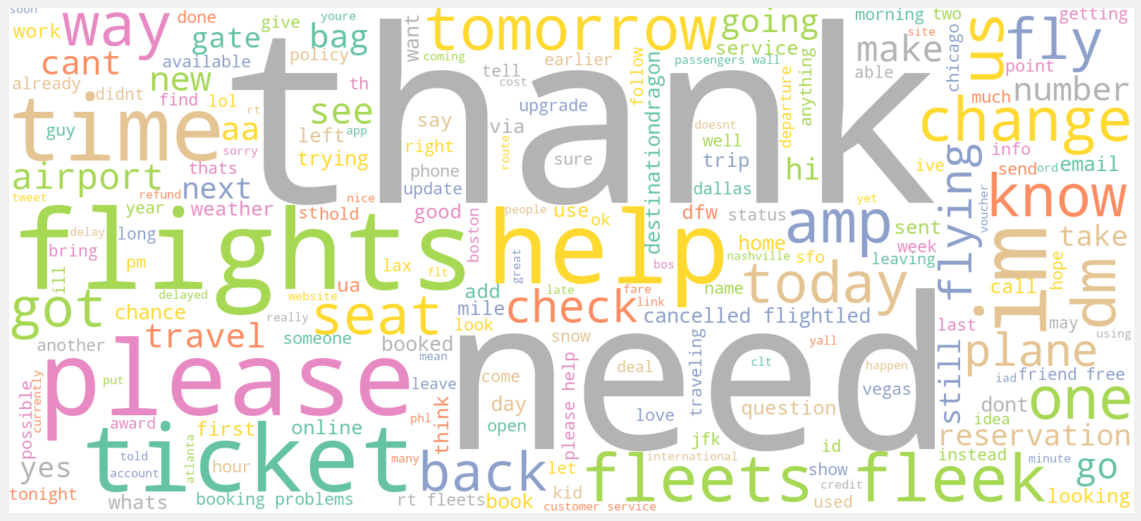

In [37]:
plt.figure(figsize=(18,15))
wc_neutral = WordCloud(min_font_size=3,max_words=200,width=1600,height=720,
                       colormap = 'Set2', background_color='white').generate(neutral)

plt.imshow(wc_neutral,interpolation='bilinear')
plt.xticks([])
plt.yticks([])
plt.grid(False)

<br>
το ουδέτερο είναι απλώς ουδέτερο. Η μόνη θετική λέξη που μπορούμε να δούμε με μια ματιά είναι «ευχαριστώ».
Σχεδόν καθόλου αρνητικά και θετικά λόγια.
<br>

<br>

### Προσέγγιση μηχανικής μάθησης

Η προσέγγιση ML είναι επίσης γνωστή ως Document Classification. Χρησιμοποιεί αλγόριθμο ML/DL για την ταξινόμηση των δεδομένων κειμένου.

Το πιο σημαντικό στην προσέγγιση ML είναι η μετατροπή του κειμένου σε διανυσματική ή άλλη αριθμητική μορφή για να κατανοήσουν οι αλγόριθμοι το κείμενο ως χαρακτηριστικό.


* Vectorization : `CountVectorizer`, `TfidfTransformer`, `Word2Vec`
* Model: Logistic Regression, RandomForest, MultinomialNB, SupportVectorMachine, BiLSTM

In [38]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [39]:
df.final_text

0                                         [dhepburn, said]
1        [plus, youve, added, commercials, experience, ...
2        [didnt, today, must, mean, need, take, another...
3        [really, aggressive, blast, obnoxious, enterta...
4                                [really, big, bad, thing]
                               ...                        
14635                     [thank, got, different, chicago]
14636    [leaving, minutes, late, warnings, communicati...
14637                          [please, bring, blackberry]
14638    [money, change, dont, answer, phones, suggesti...
14639    [ppl, need, know, many, seats, next, plz, put,...
Name: final_text, Length: 14640, dtype: object

In [40]:
for i in range(len(df)):
    df['final_text'][i] = " ".join(df['final_text'][i])

In [41]:
df['final_text'][:3]

0                                    dhepburn said
1    plus youve added commercials experience tacky
2     didnt today must mean need take another trip
Name: final_text, dtype: object

In [42]:
def convert_Sentiment(sentiment):
    if  sentiment == "positive":
        return 2
    elif sentiment == "neutral":
        return 1
    elif sentiment == "negative":
        return 0
    
df.sentiment = df.sentiment.apply(lambda x : convert_Sentiment(x))

In [43]:
X = df.final_text
y = df.sentiment

<br>

#### CountVectorizer & TfidfVectorizer

In [44]:
model_params = {'random_state':42}
model_list = [LogisticRegression(**model_params, solver='liblinear'),
              RandomForestClassifier(**model_params),
              MultinomialNB(),
              SVC(**model_params)]
model_names = ['LogisticRegression', 'RandomForest', 'MultinomialNB', 'SupportVectorMachine']

c = CountVectorizer()
X_c = c.fit_transform(X)

tf = TfidfVectorizer()
X_tf = tf.fit_transform(X)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for model, model_name in zip(model_list, model_names):
    for n_fold, (trn_idx, vld_idx) in enumerate(skf.split(df.index, df.sentiment)):        
        X_c_trn = X_c[trn_idx]
        X_tf_trn = X_tf[trn_idx]
        y_trn = df.loc[trn_idx, 'sentiment']
        
        X_c_vld = X_c[vld_idx]
        X_tf_vld = X_tf[vld_idx]
        y_vld = df.loc[vld_idx, 'sentiment']        
        
        model.fit(X_c_trn, y_trn)
        c_pred_col = f"{model_name}_ct_pred"
        df.loc[vld_idx, c_pred_col] = model.predict(X_c_vld)
        
        model.fit(X_tf_trn, y_trn)
        tf_pred_col = f"{model_name}_tf_pred"
        df.loc[vld_idx, tf_pred_col] = model.predict(X_tf_vld)

    print(f"Model: {model_name}, CountVectorizer, Accuracy: {accuracy_score(df.sentiment, df[c_pred_col]):.3%}")
    print(f"Model: {model_name}, TfidfVectorizer, Accuracy: {accuracy_score(df.sentiment, df[tf_pred_col]):.3%}\n")

Model: LogisticRegression, CountVectorizer, Accuracy: 78.921%
Model: LogisticRegression, TfidfVectorizer, Accuracy: 76.858%

Model: RandomForest, CountVectorizer, Accuracy: 76.926%
Model: RandomForest, TfidfVectorizer, Accuracy: 76.660%

Model: MultinomialNB, CountVectorizer, Accuracy: 76.100%
Model: MultinomialNB, TfidfVectorizer, Accuracy: 68.730%

Model: SupportVectorMachine, CountVectorizer, Accuracy: 77.152%
Model: SupportVectorMachine, TfidfVectorizer, Accuracy: 76.701%



<br>

#### Word2Vec 

Το Word2Vec είναι ένα από τα πιο δημοφιλή μοντέλα για την αναπαράσταση μιας λέξης σε ένα μεγάλο σώμα κειμένου ως διάνυσμα σε n-διάστατο χώρο.

Υπάρχουν δύο είδη W2V, το Continuous Bag-of-Words (CBOW) και το Skip-Gram.

Το Skip-gram χρησιμοποιείται για την πρόβλεψη της λέξης περιβάλλοντος για μια δεδομένη λέξη-στόχο. Είναι το αντίστροφο του αλγόριθμου CBOW. Εδώ, η λέξη-στόχος είναι είσοδος ενώ οι λέξεις περιβάλλοντος εξάγονται.

Στις περισσότερες περιπτώσεις είναι γνωστό ότι η προβλεψιμότητα του skip-gram είναι καλύτερη από αυτή του CBOW.

Μπορούμε να χρησιμοποιήσουμε τη βιβλιοθήκη «Word2Vec» από το «gensim» και να ορίσουμε την επιλογή «sg» που είναι το skip-gram.
    
* 1, if you want to set skip-gram and 0 for CBOW.

In [45]:
from gensim.models import Word2Vec

texts_w2v = df.final_text.apply(tokenize).to_list()

w2v = Word2Vec(sentences = texts_w2v, window = 3,
               vector_size = 100, min_count = 5, workers = 4, sg = 1)

In [46]:
texts_w2v[:3]

[['dhepburn', 'said'],
 ['plus', 'youve', 'added', 'commercials', 'experience', 'tacky'],
 ['didnt', 'today', 'must', 'mean', 'need', 'take', 'another', 'trip']]

<br>

`Word2Vec` imported from `gensim` εκπαιδεύει τα κείμενα την ίδια στιγμή που δηλώνονται από τον χρήστη.

Μπορούμε να βρούμε τις παρόμοιες λέξεις με τη δεδομένη λέξη και τα παραδείγματα παρουσιάζονται παρακάτω.

<br>

In [47]:
w2v.wv.most_similar('thank')

[('appreciate', 0.9692679047584534),
 ('much', 0.9646507501602173),
 ('amazing', 0.9579932689666748),
 ('awesome', 0.9534258842468262),
 ('thanks', 0.9528570771217346),
 ('love', 0.9488410353660583),
 ('quick', 0.9469972848892212),
 ('response', 0.9343418478965759),
 ('best', 0.9316027164459229),
 ('twitter', 0.9288391470909119)]

In [48]:
w2v.wv.most_similar('customerservice')

[('abysmal', 0.9935978651046753),
 ('cs', 0.9927898645401001),
 ('est', 0.9926360249519348),
 ('neveragain', 0.992551863193512),
 ('shitty', 0.9913198947906494),
 ('frustrating', 0.9908958673477173),
 ('literally', 0.9907767176628113),
 ('excuse', 0.9904064536094666),
 ('unhappy', 0.9902195930480957),
 ('met', 0.9895256161689758)]

In [49]:
w2v.wv.most_similar('crew')

[('ground', 0.9370158910751343),
 ('pilot', 0.9115036129951477),
 ('air', 0.9019080996513367),
 ('landing', 0.8865077495574951),
 ('passengers', 0.8853988647460938),
 ('clt', 0.8843857645988464),
 ('planes', 0.8823999166488647),
 ('communication', 0.8806120157241821),
 ('ua', 0.8767514824867249),
 ('attendant', 0.8766961097717285)]

In [50]:
w2v.wv.most_similar('delay')

[('delayed', 0.9257006645202637),
 ('stuck', 0.9103569984436035),
 ('runway', 0.9039478302001953),
 ('tarmac', 0.9007310271263123),
 ('ua', 0.8931721448898315),
 ('departure', 0.8876798748970032),
 ('half', 0.8850659728050232),
 ('sat', 0.881232738494873),
 ('issues', 0.8807033896446228),
 ('ewr', 0.8790867328643799)]

In [51]:
w2v.wv.most_similar('bag')

[('baggage', 0.9325398206710815),
 ('luggage', 0.9004399180412292),
 ('bags', 0.8994985222816467),
 ('checked', 0.8938538432121277),
 ('carry', 0.8751355409622192),
 ('claim', 0.8535147905349731),
 ('check', 0.8309581279754639),
 ('found', 0.8253761529922485),
 ('extra', 0.8199068903923035),
 ('open', 0.8167956471443176)]

In [52]:
w2v.wv.most_similar('ticket')

[('fee', 0.9416543841362),
 ('refund', 0.9367069005966187),
 ('name', 0.9253697395324707),
 ('award', 0.9222201108932495),
 ('online', 0.9181504249572754),
 ('credit', 0.9169402718544006),
 ('using', 0.9140844941139221),
 ('booked', 0.9123185276985168),
 ('website', 0.9057668447494507),
 ('change', 0.9052973389625549)]

In [53]:
w2v.wv.most_similar('booking')

[('reflight', 0.8968310952186584),
 ('problems', 0.8005267977714539),
 ('fee', 0.7829848527908325),
 ('using', 0.7696842551231384),
 ('website', 0.7323207855224609),
 ('options', 0.7312647700309753),
 ('ticket', 0.7284455299377441),
 ('process', 0.7227106094360352),
 ('name', 0.7154735326766968),
 ('online', 0.7078397870063782)]

In [54]:
def get_avg_vector(sent):
    vector = np.zeros(100)
    total_words = 0
    for word in sent.split():        
        if word in w2v.wv.index_to_key:    # don't use .wv.vocab method in kaggle notebook. instead, use .wv.index_to_key method.
            vector += w2v.wv.word_vec(word)
            total_words += 1
    if total_words > 0:
        return vector / total_words
    else:
        return vector
    
df['w2v_vector'] = df['final_text'].map(get_avg_vector)
df[['final_text', 'w2v_vector']].head(2)

,final_text,w2v_vector
0,dhepburn said,"[-0.045269470661878586, 0.19181980192661285, 0..."
1,plus youve added commercials experience tacky,"[0.03838816215284169, 0.17547699958086013, 0.0..."


In [55]:
model_params = {'random_state':42}
model_list = [LogisticRegression(**model_params, solver='liblinear'),
              RandomForestClassifier(**model_params),
#               MultinomialNB(),  # Don't use Naive Bayes since w2v_vector contains negative numbers, then it causes an error.
              SVC(**model_params)]
model_name = ['LogisticRegression', 'RandomForest', 'SupportVectorMachine']

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for model, model_name in zip(model_list, model_name):
    for n_fold, (trn_idx, vld_idx) in enumerate(skf.split(df.index, df.sentiment)):        
        X_trn = np.stack(df.loc[trn_idx, 'w2v_vector'])
        y_trn = df.loc[trn_idx, 'sentiment']
        
        X_vld = np.stack(df.loc[vld_idx, 'w2v_vector'])
        y_vld = df.loc[vld_idx, 'sentiment']        
        
        model.fit(X_trn, y_trn)
        pred_col = f"{model_name}_w2v_pred"
        df.loc[vld_idx, pred_col] = model.predict(X_vld)
        

    print(f"Model: {model_name}, Word2Vec, Accuracy: {accuracy_score(df.sentiment, df[pred_col]):.3%}\n")

Model: LogisticRegression, Word2Vec, Accuracy: 71.107%

Model: RandomForest, Word2Vec, Accuracy: 72.937%

Model: SupportVectorMachine, Word2Vec, Accuracy: 69.939%



<br>

Διαπιστώσαμε ότι τα αποτελέσματα δεν βελτιώνονται στους παραδοσιακούς αλγόριθμους ML.

Είναι γνωστό ότι το αποτέλεσμα από τη χρήση embedding vector όπως το Word2Vec συνήθως μεγιστοποιείται χρησιμοποιώντας μοντέλο ακολουθίας όπως το RNN.

Θα δοκιμάσω το BiLSTM.

<br>

#### LSTM 

In [58]:
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Bidirectional,Embedding, Dropout, Conv1D, MaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping

In [59]:
max_words = 5000
max_len = 100

def tokenize_pad_sequences(text):
    '''
    This function tokenize the input text into sequnences of intergers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)
    # return sequences
    return X, tokenizer

print('Before Tokenization & Padding \n', df['final_text'][0],'\n')
X, tokenizer = tokenize_pad_sequences(df['final_text'])
print('After Tokenization & Padding \n', X[0])

Before Tokenization & Padding 
 dhepburn said 

After Tokenization & Padding 
 [125   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]


In [60]:
y = pd.get_dummies(df.sentiment)
X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_trn, X_vld, y_trn, y_vld = train_test_split(X_trn, y_trn, test_size=0.3, random_state=42, stratify=y_trn)

print('Train:         ', X_trn.shape, y_trn.shape)
print('Validation Set:', X_vld.shape, y_vld.shape)
print('Test Set:      ', X_tst.shape, y_tst.shape)

Train:          (8198, 100) (8198, 3)
Validation Set: (3514, 100) (3514, 3)
Test Set:       (2928, 100) (2928, 3)


In [61]:
vocab_size = 5000
embedding_size = 32
epochs=50

model= Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))

plot_model(model, show_shapes = True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [62]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 32)           160000    
                                                                 
 conv1d (Conv1D)             (None, 100, 32)           3104      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 50, 32)           0         
 )                                                               
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 3)                 1

In [63]:
es = EarlyStopping(monitor = 'val_loss', patience=5)
batch_size = 64

history = model.fit(X_trn, y_trn,
                    validation_data=(X_vld, y_vld),
                    batch_size=batch_size, epochs=epochs, verbose=1,
                    callbacks = [es])

Epoch 1/50
129/129 [==============================] - 4s 19ms/step - loss: 0.8641 - accuracy: 0.6342 - val_loss: 0.6874 - val_accuracy: 0.6918
Epoch 2/50
129/129 [==============================] - 2s 14ms/step - loss: 0.6072 - accuracy: 0.7349 - val_loss: 0.5975 - val_accuracy: 0.7621
Epoch 3/50
129/129 [==============================] - 2s 14ms/step - loss: 0.4662 - accuracy: 0.8162 - val_loss: 0.6115 - val_accuracy: 0.7735
Epoch 4/50
129/129 [==============================] - 2s 14ms/step - loss: 0.3614 - accuracy: 0.8696 - val_loss: 0.6268 - val_accuracy: 0.7723
Epoch 5/50
129/129 [==============================] - 2s 14ms/step - loss: 0.2786 - accuracy: 0.9064 - val_loss: 0.6561 - val_accuracy: 0.7766
Epoch 6/50
129/129 [==============================] - 2s 14ms/step - loss: 0.2197 - accuracy: 0.9252 - val_loss: 0.7803 - val_accuracy: 0.7692
Epoch 7/50
129/129 [==============================] - 2s 14ms/step - loss: 0.1744 - accuracy: 0.9404 - val_loss: 0.8366 - val_accuracy: 0.7624

In [64]:
# Evaluate model on the test set
loss, accuracy = model.evaluate(X_tst, y_tst, verbose=0)

# Print metrics
print('Accuracy  : {:.4f}'.format(accuracy))

Accuracy  : 0.7698


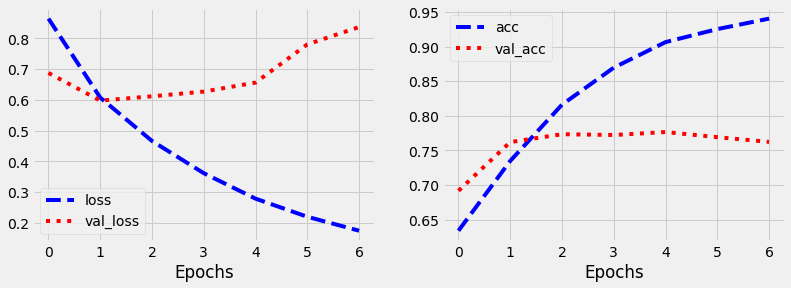

In [65]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b--', label = 'loss')
plt.plot(history.history['val_loss'], 'r:', label = 'val_loss')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'b--', label = 'acc')
plt.plot(history.history['val_accuracy'], 'r:', label = 'val_acc')
plt.xlabel('Epochs')
plt.legend()

plt.show()

92/92 [==============================] - 1s 3ms/step


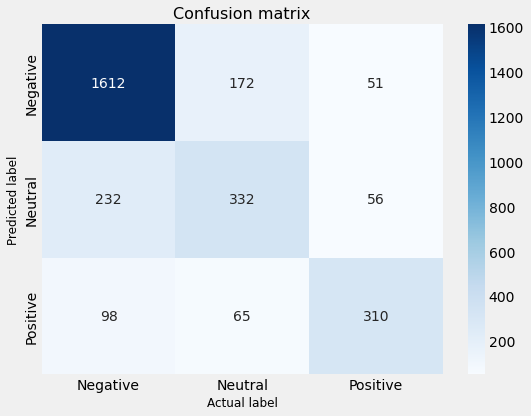

In [66]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''
    
    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    # use model to do the prediction
    y_pred = model.predict(X_test)
    # compute confusion matrix
    cm = confusion_matrix(np.argmax(np.array(y_test),axis=1), np.argmax(y_pred, axis=1))
    # plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)
    
plot_confusion_matrix(model, X_tst, y_tst)

<br>

Τα αποτελέσματα παραμένουν τα ίδια με τις άλλες μεθόδος και το accuracy στο 75%

In [67]:
# Save the model architecture & the weights
model.save('best_model.h5')
print('Best model saved')

Best model saved


### References

[Notebook1](https://www.kaggle.com/kritanjalijain/twitter-sentiment-analysis-lstm#Bidirectional-LSTM-Using-NN)

[Notebook2](https://github.com/TannerGilbert/Tutorials/blob/master/Keras-Tutorials/6.%20Sentiment%20Analysis/Sentiment%20Analysis.ipynb)

[Notebook3](https://www.kaggle.com/meisamraz/sentiment-analysis-96-acc-eda-text-preprocessing/notebook)

[Blog1](https://medium.datadriveninvestor.com/word2vec-skip-gram-model-explained-383fa6ddc4ae)